In [28]:
import pandas as pd
import json
import numpy as np
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import scipy.stats as stats

In [29]:
colors=['#19bdff','#f2d138'] #majority/minority
greycolor='#626262'
myblack='#222222'
# repcolor='red'
# demcolor='blue'
mygrey='#cfcfcf'
myred= '#f2d138' #'#ea9999'
mygreen= '#19bdff' #'#93c47d'
mypurple = '#7E57C2'

TINY_SIZE = 9
SMALL_SIZE = 10
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

dpival=100

mpl.rcParams['figure.dpi'] = dpival

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=TINY_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [30]:

Q1_choices=["Acknowledges","Neutral","Denies","Debate"]
Q2_choices=["Expresses climate concern","Neutral","Expresses opposition to climate concern","Debate"]
Q3_choices=["Supports","Neutral","Opposes","Debate","Does not mention"]
short_Q2_choices=['Concern',
 'Neutral',
 'Opposition',
 'Debate'] 
short_Q3_choices=Q3_choices[:-2] #cut "does not mention"


In [31]:
df = pd.read_csv('input/allQ_df.csv', index_col=0)

In [32]:
df.head()

,internal_id,media_outlet,climate_change,attitude,policy
0,0,CNN,Acknowledges,Expresses climate concern,Supports
1,0,CNN,Acknowledges,Expresses climate concern,Supports
2,1,CBS,Neutral,Expresses climate concern,Does not mention
3,1,CBS,Neutral,Expresses climate concern,Does not mention
4,2,Fox,Neutral,Neutral,Opposes


In [33]:
df = df.dropna() ## drop unclears

In [34]:
import pandas as pd
import numpy as np
from scipy.stats import entropy


# Function to compute distributions
def compute_distributions(df):
    mode_counts = {k: 0 for k in Q3_choices}
    weighted_counts = {k: 0 for k in Q3_choices}

    grouped = df.groupby("internal_id")["policy"].apply(list)

    # Simulate random choice multiple times for better averaging
    num_simulations = 1000
    random_sim_results = {k: 0 for k in Q3_choices}

    for policies in grouped:
        # Mode-based distribution
        mode_policy = max(set(policies), key=policies.count)
        mode_counts[mode_policy] += 1

        # Weight-based distribution (each policy gets 0.5 count)
        for policy in policies:
            weighted_counts[policy] += 0.5

        # Random-based distribution
        for _ in range(num_simulations):
            random_choice = np.random.choice(policies)
            random_sim_results[random_choice] += 1

    # Convert counts to probability distributions
    mode_dist = np.array([mode_counts[k] for k in Q3_choices]) / sum(mode_counts.values())
    weighted_dist = np.array([weighted_counts[k] for k in Q3_choices]) / sum(weighted_counts.values())
    random_dist = np.array([random_sim_results[k] for k in Q3_choices]) / sum(random_sim_results.values())

    return mode_dist, weighted_dist, random_dist

# Compute distributions
mode_dist, weighted_dist, random_dist = compute_distributions(df)

# Jensen-Shannon Divergence function
def js_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * (entropy(p, m) + entropy(q, m))

# Compute JS divergences between distributions
js_mode_weighted = js_divergence(mode_dist, weighted_dist)
js_mode_random = js_divergence(mode_dist, random_dist)
js_weighted_random = js_divergence(weighted_dist, random_dist)

# Print results
print("Mode Distribution:", mode_dist)
print("Weighted Distribution:", weighted_dist)
print("Random Distribution:", random_dist)
print("JS Divergence (Mode vs Weighted):", js_mode_weighted)
print("JS Divergence (Mode vs Random):", js_mode_random)
print("JS Divergence (Weighted vs Random):", js_weighted_random)


Mode Distribution: [0.15940594 0.08267327 0.06633663 0.00792079 0.68366337]
Weighted Distribution: [0.1631435  0.10047252 0.06863964 0.01044516 0.65729918]
Random Distribution: [0.16290446 0.10018218 0.06931386 0.01065545 0.65694406]
JS Divergence (Mode vs Weighted): 0.0006704061058364292
JS Divergence (Mode vs Random): 0.0006797586542035983
JS Divergence (Weighted vs Random): 1.5205245096228131e-06


In [35]:

# Function to compute distributions and track mismatched internal_ids
def compute_distributions_and_mismatches(df):
    mode_counts = {k: 0 for k in Q3_choices}
    weighted_counts = {k: 0 for k in Q3_choices}
    mismatched_ids = []

    grouped = df.groupby("internal_id")["policy"].apply(list)

    for internal_id, policies in grouped.items():
        # Mode-based policy
        mode_policy = max(set(policies), key=policies.count)

        # Weighted policy: Compute weights
        weight_distribution = {k: 0 for k in Q3_choices}
        for policy in policies:
            weight_distribution[policy] += 0.5

        # Find the policy with the highest weighted count
        weighted_policy = max(weight_distribution, key=weight_distribution.get)

        # Store counts for final distribution calculation
        mode_counts[mode_policy] += 1
        for policy, count in weight_distribution.items():
            weighted_counts[policy] += count

        # Check for mismatch
        if mode_policy != weighted_policy:
            mismatched_ids.append(internal_id)

    # Convert counts to probability distributions
    mode_dist = np.array([mode_counts[k] for k in Q3_choices]) / sum(mode_counts.values())
    weighted_dist = np.array([weighted_counts[k] for k in Q3_choices]) / sum(weighted_counts.values())

    return mode_dist, weighted_dist, mismatched_ids

# Compute distributions and mismatches
mode_dist, weighted_dist, mismatched_ids = compute_distributions_and_mismatches(df)

# Print results
print("Mode Distribution:", mode_dist)
print("Weighted Distribution:", weighted_dist)


Mode Distribution: [0.15940594 0.08267327 0.06633663 0.00792079 0.68366337]
Weighted Distribution: [0.1631435  0.10047252 0.06863964 0.01044516 0.65729918]


In [36]:
len(mismatched_ids)

118

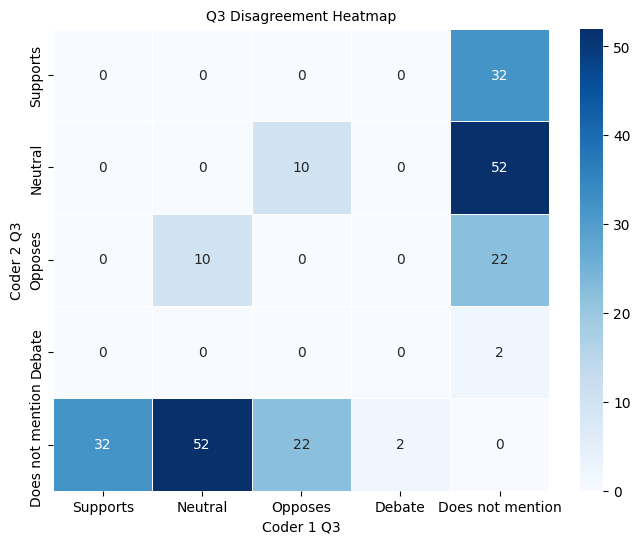

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


grouped = df.groupby("internal_id")["policy"].apply(list)

# Extract policy pairs for mismatched IDs
policy_pairs = [
    tuple(grouped[id]) for id in mismatched_ids
]

# Create frequency matrix
heatmap_matrix = pd.DataFrame(0, index=Q3_choices, columns=Q3_choices)

for p1, p2 in policy_pairs:
    heatmap_matrix.loc[p1, p2] += 1
    heatmap_matrix.loc[p2, p1] += 1  # Make it symmetric

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_matrix, annot=True, cmap="Blues", fmt="d", linewidths=0.5)
plt.xlabel("Coder 1 Q3")
plt.ylabel("Coder 2 Q3")
plt.title("Q3 Disagreement Heatmap")
plt.show()


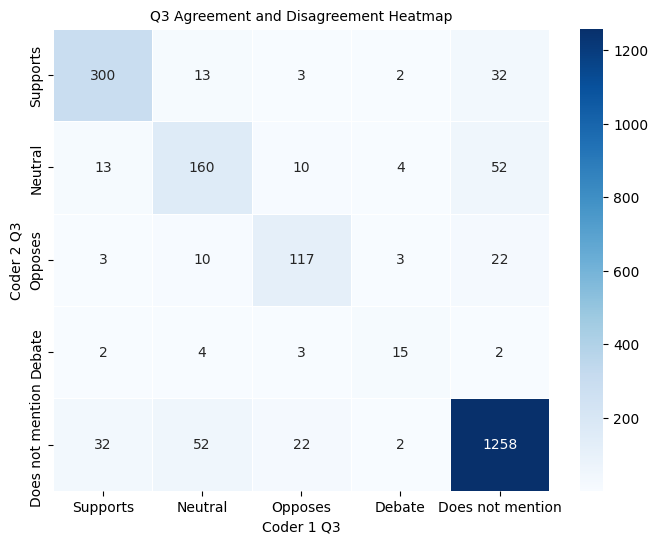

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Group by internal_id and extract policy pairs
grouped = df.groupby("internal_id")["policy"].apply(list)

# Create frequency matrix (initialize to zero)
heatmap_matrix = pd.DataFrame(0, index=Q3_choices, columns=Q3_choices)

# Populate matrix with unique (entry1, entry2) policy pairs
for policies in grouped:
    if len(policies) == 2:  # Ensure there are exactly two entries per internal_id
        p1, p2 = sorted(policies)  # Sort to prevent double-counting
        heatmap_matrix.loc[p1, p2] += 1  # Only count once
        if p1 != p2:
            heatmap_matrix.loc[p2, p1] += 1  # No extra counting for symmetric entries

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_matrix, annot=True, cmap="Blues", fmt="d", linewidths=0.5)
plt.xlabel("Coder 1 Q3")
plt.ylabel("Coder 2 Q3")
plt.title("Q3 Agreement and Disagreement Heatmap")
plt.show()


4021